# imports


In [19]:
import os, glob
import time
from functools import reduce
from os import path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import pandas as pd


#single server
avg_cpu_load = '/avg_cpu_load'
avg_heap = '/avg_heap'
avg_memory = '/avg_memory'
avg_num_cores = '/avg_num_cores'
cpu_user_util = '/cpu_user_util'
max_cpu_load = '/max_cpu_load'
max_heap = '/max_heap'
p99_response_time = '/p99_response_time'
reco_rate = '/reco_rate'
load_score_meter = '/load_score_meter'
#cross dc
avg_cpu_load_DC = '/avg(node_load15{hostname=~_^water._}) by (domain)'
avg_heap_DC = '/avg_heap'
avg_memory_Dc = '/avg(avg(node_memory_MemTotal_bytes{hostname=~_^water._})) by (hostname)'
avg_num_cores_Dc = '/avg(count (node_cpu_seconds_total{mode=_idle_,hostname=~_^water._,job=~_node_exporter_}) by (hostname))'
max_cpu_load_Dc = '/max(node_load15{hostname=~_^water._}) by (domain)'
max_heap_Dc = '/max_heap'
p99_response_time_Dc = '/trc_requests_timer_p99_weighted_dc'
reco_rate_Dc = '/recommendation_requests_5m_rate_dc'



paths_cross_dc = [[avg_cpu_load_DC, 'avg_cpu_load'], [avg_heap_DC, 'avg_heap'], [avg_memory_Dc, 'avg_memory']
    , [avg_num_cores_Dc, 'avg_num_cores'], [max_cpu_load_Dc, 'cpu_user_util'],
         [max_cpu_load_Dc, 'max_cpu_load'], [max_heap_Dc, 'max_heap']
    , [p99_response_time_Dc, 'p99_response_time'], [reco_rate_Dc, 'reco_rate']]

paths_server = [[avg_cpu_load, 'avg_cpu_load'], [avg_heap, 'avg_heap'], [avg_memory, 'avg_memory']
    , [avg_num_cores, 'avg_num_cores'], [cpu_user_util, 'cpu_user_util'],
         [max_cpu_load, 'max_cpu_load'], [max_heap, 'max_heap']
    , [p99_response_time, 'p99_response_time'], [reco_rate, 'reco_rate'], [load_score_meter, 'load_score_meter']]



# Data/Single servers/AM/40 cores 187.35 GB
data_path_servers  = 'Data/Single servers'
data_path_cross_Dc = 'Data/Cross DC'
cores_32_path = '32 cores 125.6 GB'
cores_40_path = '40 cores 187.35 GB'
cores_48_path = '48 cores 187.19 GB'
cores_72_path = '72 cores 251.63GB'
cores_40_path_copy = '40 cores 187.35 GB - Copy'
country_AM = '/AM/'
country_IL = '/IL/'
country_LA = '/LA/'
a4_dims = (11.7, 8.27)


In [20]:
def getCsv(data_path, country, core_path, metric_path, name_of_metric):
    if data_path == data_path_cross_Dc:
        all_files = glob.glob(os.path.join(data_path + country + metric_path, "*.csv"))
    else:
        all_files = glob.glob(os.path.join(data_path + country + core_path + metric_path, "*.csv"))
    all_csv = (pd.read_csv(f, sep=',') for f in all_files)
    new_csv = pd.concat(all_csv, ignore_index=True)
    new_csv.columns = ['dates', name_of_metric]
    return new_csv


def getDataSet(paths, data_path, country, cores_path, figure_num):
    csv_data_cores = [getCsv(data_path, country, cores_path, path[0], path[1]) for path in paths]
    csv_data_cores = reduce(lambda left, right: pd.merge(left, right, on=['dates'],
                                                         how='outer'), csv_data_cores)
    csv_data_cores = csv_data_cores.dropna()
    data_to_scale_cores = csv_data_cores.drop('dates', 1)
    data_to_scale_cores = data_to_scale_cores.drop('avg_memory', 1)
    data_to_scale_cores = data_to_scale_cores.drop('avg_num_cores', 1)
    return data_to_scale_cores, csv_data_cores

In [21]:
data_to_scale_40_cores, csv_data_40_cores = getDataSet(paths_server, data_path_servers, country_AM, cores_40_path, 2)

In [22]:
csv_data_40_cores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79366 entries, 0 to 79441
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dates              79366 non-null  object 
 1   avg_cpu_load       79366 non-null  float64
 2   avg_heap           79366 non-null  float64
 3   avg_memory         79366 non-null  float64
 4   avg_num_cores      79366 non-null  float64
 5   cpu_user_util      79366 non-null  float64
 6   max_cpu_load       79366 non-null  float64
 7   max_heap           79366 non-null  int64  
 8   p99_response_time  79366 non-null  float64
 9   reco_rate          79366 non-null  float64
 10  load_score_meter   79366 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 7.3+ MB


In [23]:
data_to_scale.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 79366 entries, 0 to 79441
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_cpu_load       79366 non-null  float64
 1   avg_heap           79366 non-null  float64
 2   cpu_user_util      79366 non-null  float64
 3   max_cpu_load       79366 non-null  float64
 4   max_heap           79366 non-null  int64  
 5   p99_response_time  79366 non-null  float64
 6   reco_rate          79366 non-null  float64
 7   load_score_meter   79366 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 7.5 MB


# sacle - manual 

In [7]:
csv_data_40_cores = csv_data_40_cores.drop('avg_num_cores', 1)
csv_data_40_cores = csv_data_40_cores.drop('avg_memory', 1)
data_to_scale = csv_data_40_cores.drop('dates', 1)
normalized_df_all_dates=(data_to_scale-data_to_scale.min())/(data_to_scale.max()-data_to_scale.min())
normalized_df_all_dates = normalized_df_all_dates.merge(
    right=csv_data_40_cores['dates'],
    left_index=True,
    right_index=True,
    suffixes=['', '_norm'])
normalized_df_all_dates_graph = normalized_df_all_dates.melt('dates', var_name='all_data',  value_name='vals')

# heat_map

<AxesSubplot:>

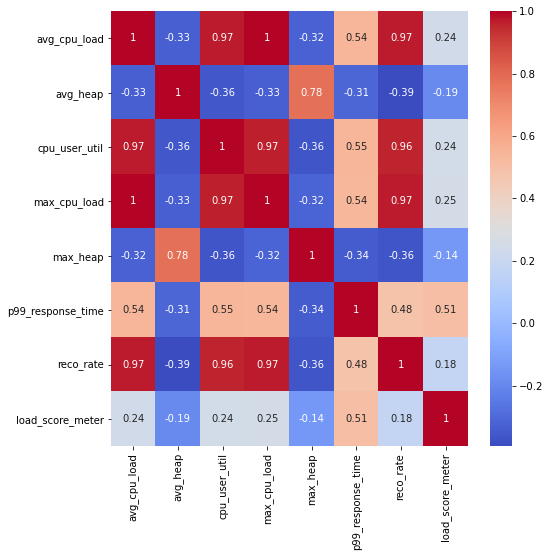

In [24]:
f, ax = plt.subplots(figsize = (8, 8))
sns.heatmap(data_to_scale.corr(), annot = True,cmap='coolwarm')

In [13]:
def add_multiply( dataset):
    feature_names1 = dataset.columns
    feature_names2 = dataset.columns

    for feature1 in feature_names1:
        feature_names2 = feature_names2[1:]
        for feature2 in feature_names2:
            if (feature1 != feature2 and feature1 !=  "dates" and feature2 != "dates"):
                to_add = dataset[feature1] * dataset[feature2]
                dataset[feature1 + " * " + feature2] = to_add
    return dataset

In [25]:
data_to_scale_mul = data_to_scale[:]

In [26]:
data_to_scale_mul.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79366 entries, 0 to 79441
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_cpu_load       79366 non-null  float64
 1   avg_heap           79366 non-null  float64
 2   cpu_user_util      79366 non-null  float64
 3   max_cpu_load       79366 non-null  float64
 4   max_heap           79366 non-null  int64  
 5   p99_response_time  79366 non-null  float64
 6   reco_rate          79366 non-null  float64
 7   load_score_meter   79366 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 5.4 MB


In [28]:
multiply_data = add_multiply(data_to_scale)

In [29]:
multiply_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79366 entries, 0 to 79441
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   avg_cpu_load                          79366 non-null  float64
 1   avg_heap                              79366 non-null  float64
 2   cpu_user_util                         79366 non-null  float64
 3   max_cpu_load                          79366 non-null  float64
 4   max_heap                              79366 non-null  int64  
 5   p99_response_time                     79366 non-null  float64
 6   reco_rate                             79366 non-null  float64
 7   load_score_meter                      79366 non-null  float64
 8   avg_cpu_load * avg_heap               79366 non-null  float64
 9   avg_cpu_load * cpu_user_util          79366 non-null  float64
 10  avg_cpu_load * max_cpu_load           79366 non-null  float64
 11  avg_cpu_load * 

<AxesSubplot:>

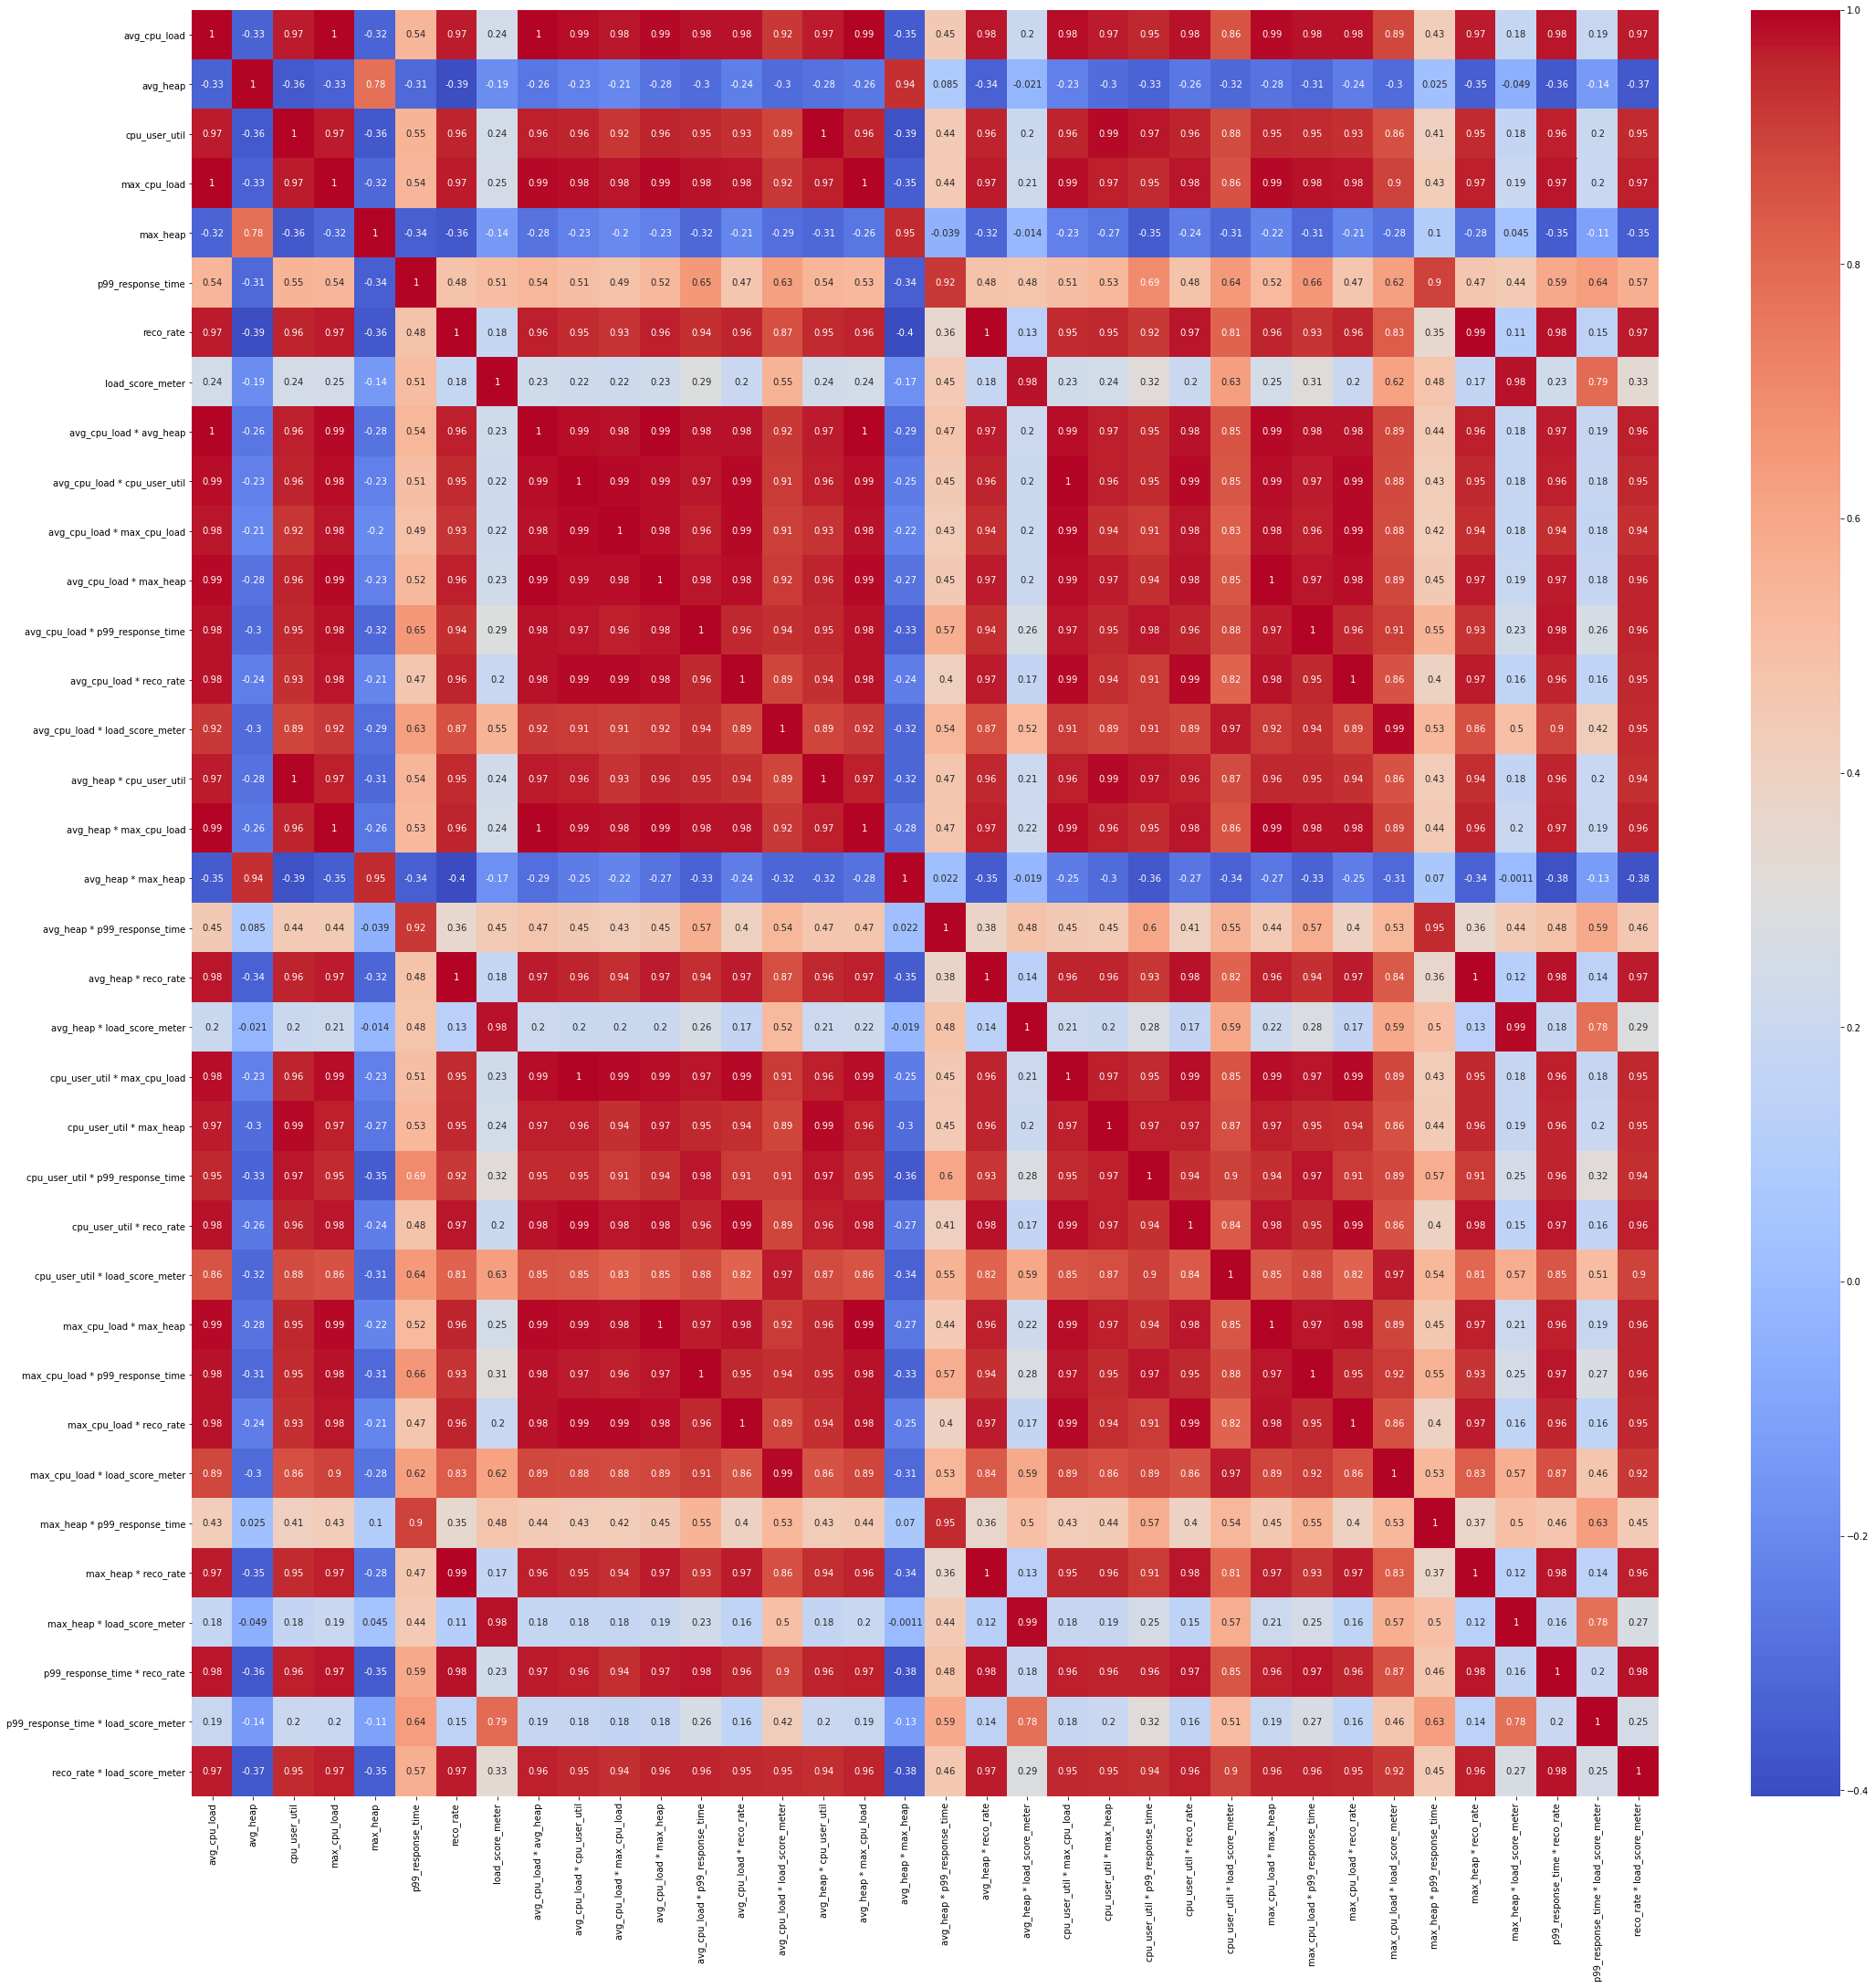

In [30]:
f, ax = plt.subplots(figsize = (36, 36))
sns.heatmap(multiply_data.corr(), annot = True,cmap='coolwarm')

a